<h1>Spacial density of Na and K in various traps</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from typing import Union

from astropy.constants import hbar, k_B

from quantum_statistics.spatial_basis import GridSpatialBasisSet

from quantum_statistics import (
    ParticleProps, 
    BoseGas, 
    FermiGas, 
    harmonic_trap,
    box_trap,
    box_2d_harmonic_1d_trap,
    ring_beam_trap,
    analyze_bec,
    analyze_fermi_gas,
    plot_condens_frac,
)

from scipy.optimize import line_search

In [2]:
blue_trap_hight_K = 250*u.nK   # for Na: *3
red_trap_depth_K = 17*100*u.nK # for Na: /17

k40_harmonic = ParticleProps(
    name="K40",
    species="fermion",
    m=39.963999*u.u,
    N_particles=200000,
    T=0, #45*u.nK,
    domain=(-70, 70)*u.um,
    #V_trap=harmonic_trap,
    V_trap=box_trap,
    #V_trap=box_2d_harmonic_1d_trap,
    trap_depth=17*100,
    box_width=(100,100,100),
    #waist=50,
    #V_trap=ring_beam_trap,
    #flat_sizes=(100, 100, 20)*u.um,
    #boundary_waists=(6, 6, 13)*u.um,
    #blue_trap_hight=blue_trap_hight_K,
    #red_trap_depth=red_trap_depth_K,
    inhomogenity=0.02,
)

na23_harmonic = ParticleProps(
    name="Na23",
    species="boson",
    m=22.989768*u.u,
    N_particles=200000,
    T=10*u.nK,
    a_s=2.75*u.nm,
    domain=(-70, 70)*u.um,
    V_trap=harmonic_trap,
    #V_trap=box_trap,
    #V_trap=box_2d_harmonic_1d_trap,
    trap_depth=100,
    #box_width=(100,100,100),
    waist=50,
    #V_trap=ring_beam_trap,
    #flat_sizes=(100, 100, 20)*u.um,
    #boundary_waists=(6, 6, 13)*u.um,
    #blue_trap_hight=3*blue_trap_hight_K,
    #red_trap_depth=red_trap_depth_K/17,
    inhomogenity=0,
)

#k40_harmonic.plot_V_trap()
#na23_harmonic.plot_V_trap()

In [3]:
bg = BoseGas(na23_harmonic, init_with_zero_T=True)

In [4]:
print("mu: ", bg.mu)
print("N_condensed", bg.N_particles_condensed)
print("N_thermal", bg.N_particles_thermal)
print("N_total", bg.N_particles)

mu:  -80.14662240576794 nK
N_condensed 199993.07939330587
N_thermal 0.0
N_total 199993.07939330587


In [5]:
bg._update_n0_with_E_functional_minimization()
bg.spatial_basis_set.integral(bg.n0_array)

<Quantity 877080.69304971>

In [6]:
bg.use_HF = True
bg._update_n_ex()
bg.spatial_basis_set.integral(bg.n_ex_array)

<Quantity 986.19511943>

In [4]:
bg.eval_density(use_TF=False, print_convergence_info_at_this_iteration=1)

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:13<21:38, 13.12s/it]

Iteration 0:
N:  1588914.1504805228
N_condensed:  1586510.3151838526
N_thermal:  2403.8352966697216
mu:  -57.404955794666584 nK
delta_mu:  0.06944570752402512
new_mu_direction:  -6.944570752402614 nK
mu_change_rate:  0.01




  2%|▏         | 2/100 [00:24<19:40, 12.05s/it]

Iteration 1:
N:  1588873.7973519266
N_condensed:  1586510.3151838526
N_thermal:  2363.4821680742157
mu:  -57.47439948453418 nK
delta_mu:  0.06944368986759741
new_mu_direction:  -6.944368986759633 nK
mu_change_rate:  0.01




  2%|▏         | 2/100 [00:33<27:06, 16.59s/it]


KeyboardInterrupt: 

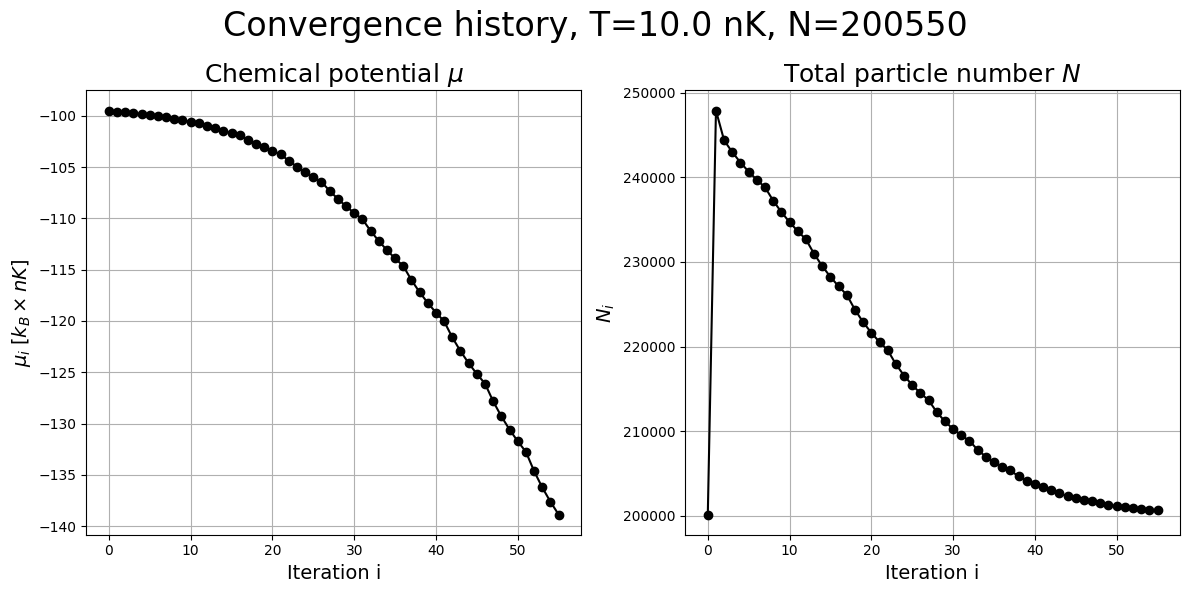

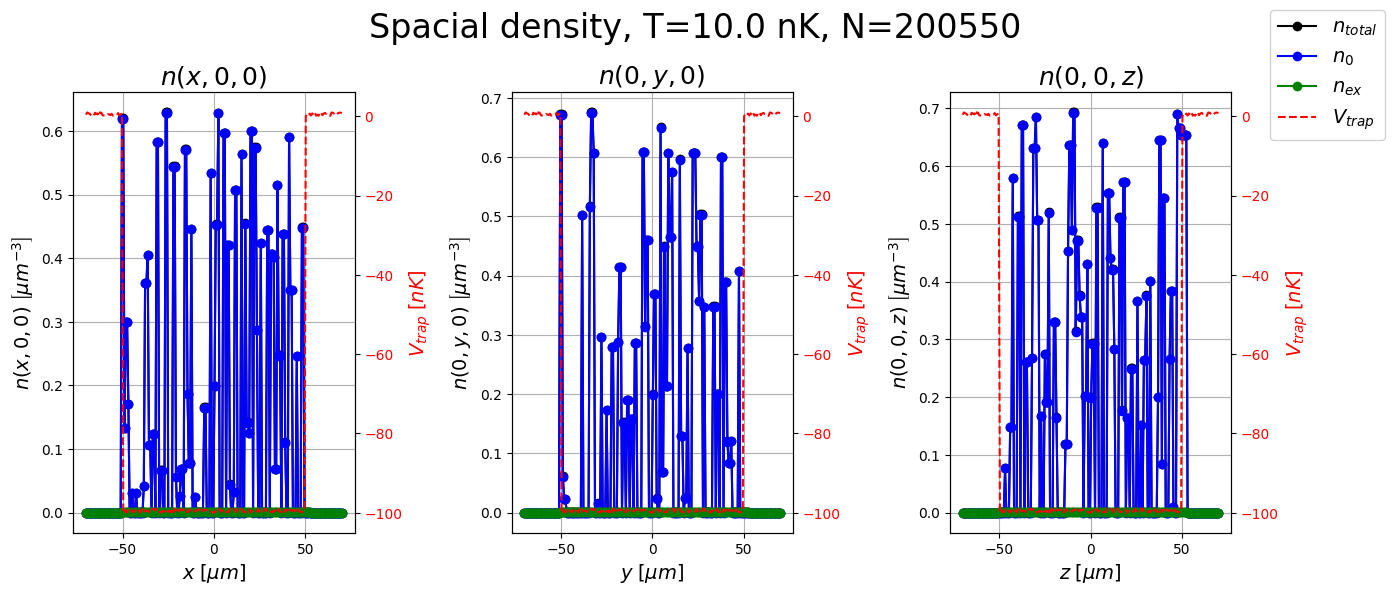

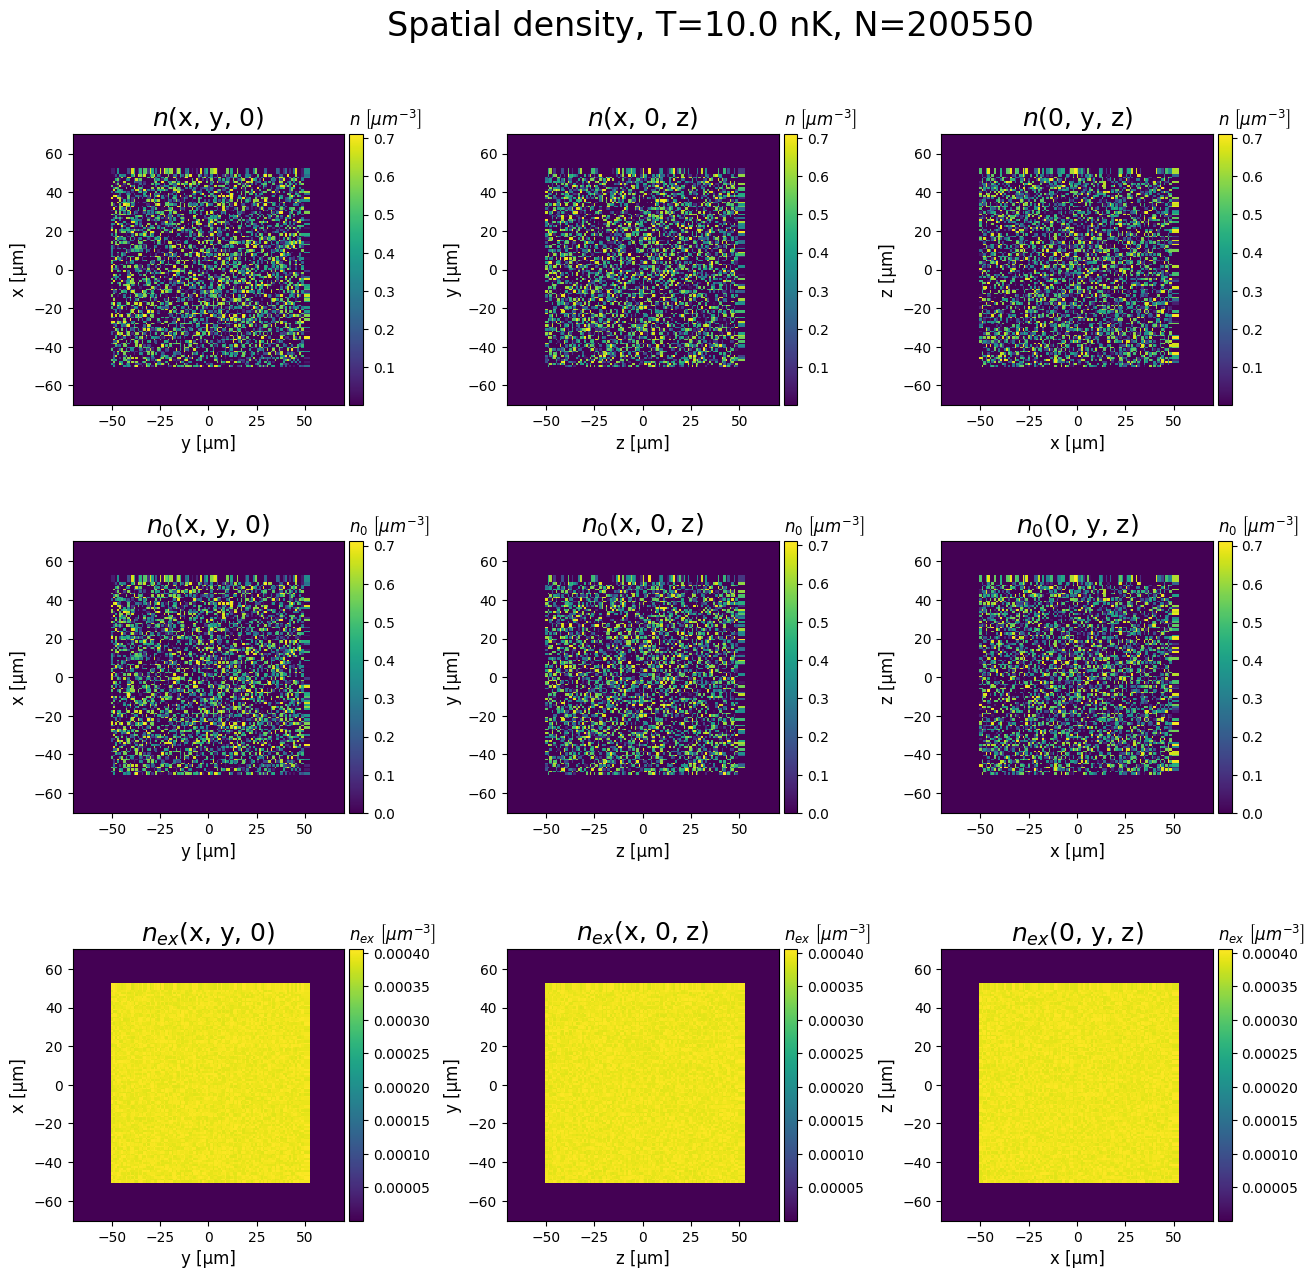

In [5]:
bg.plot_all()

In [3]:
fg = FermiGas(k40_harmonic)
fg.eval_density(use_LDA=False, use_TF=False) 

  0%|          | 0/1000 [00:00<?, ?it/s]/home/lelo/anaconda3/envs/lightmatter/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/lelo/anaconda3/envs/lightmatter/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/lelo/anaconda3/envs/lightmatter/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  0%|          | 0/1000 [06:02<?, ?it/s]

Convergence reached after 0 iterations.


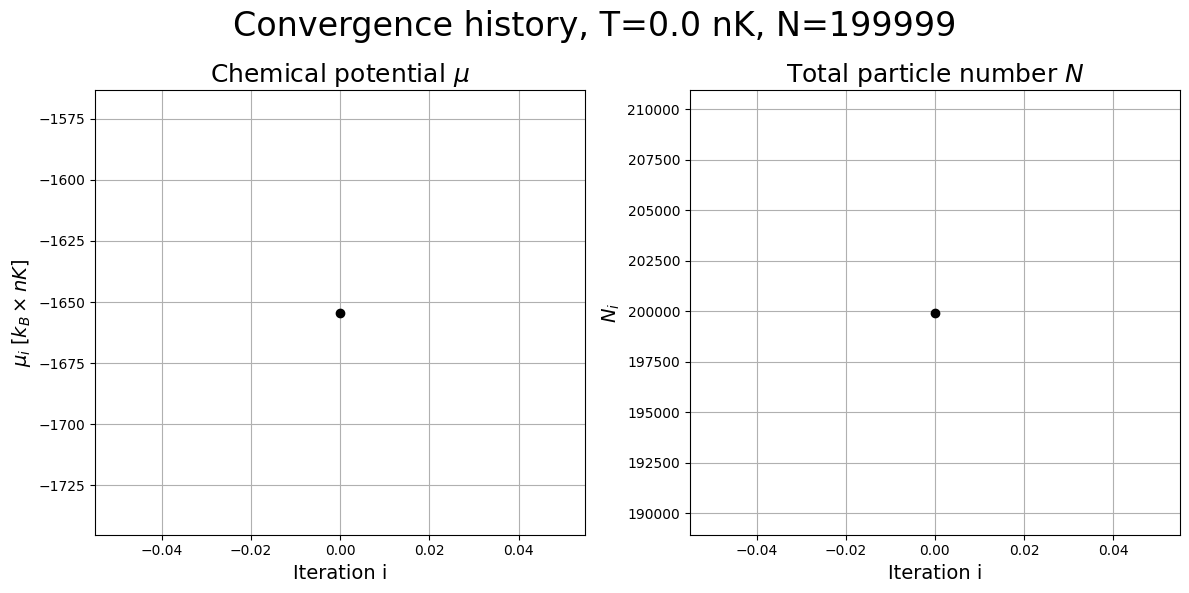

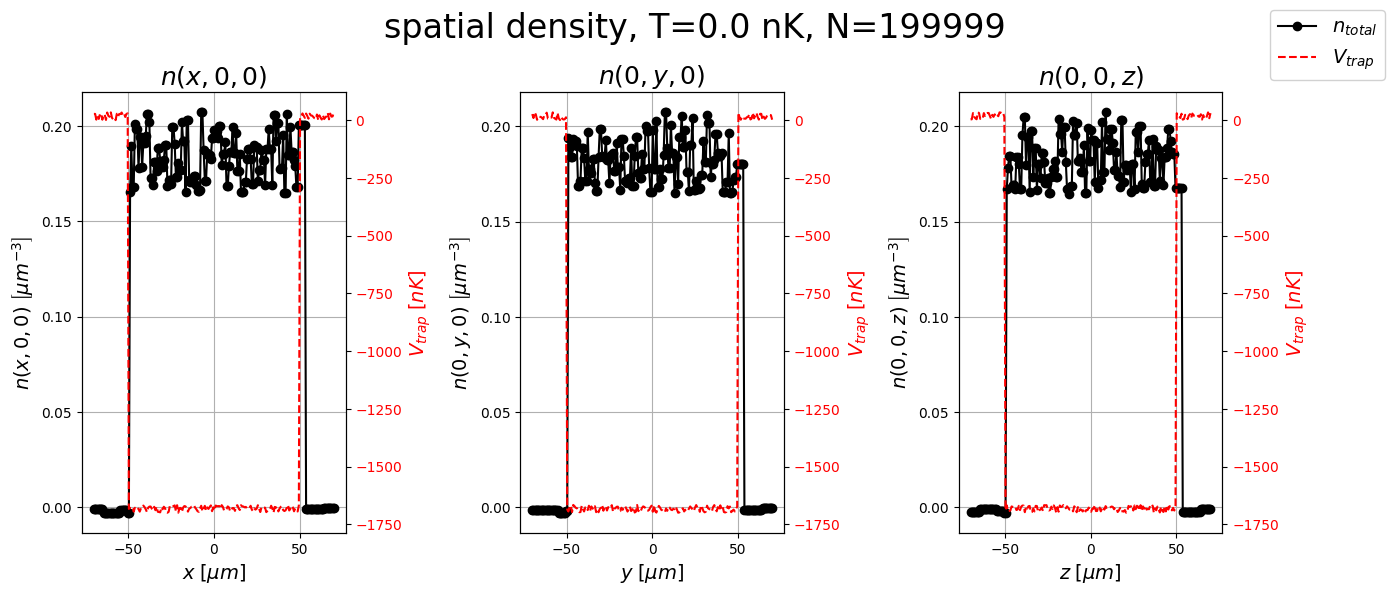

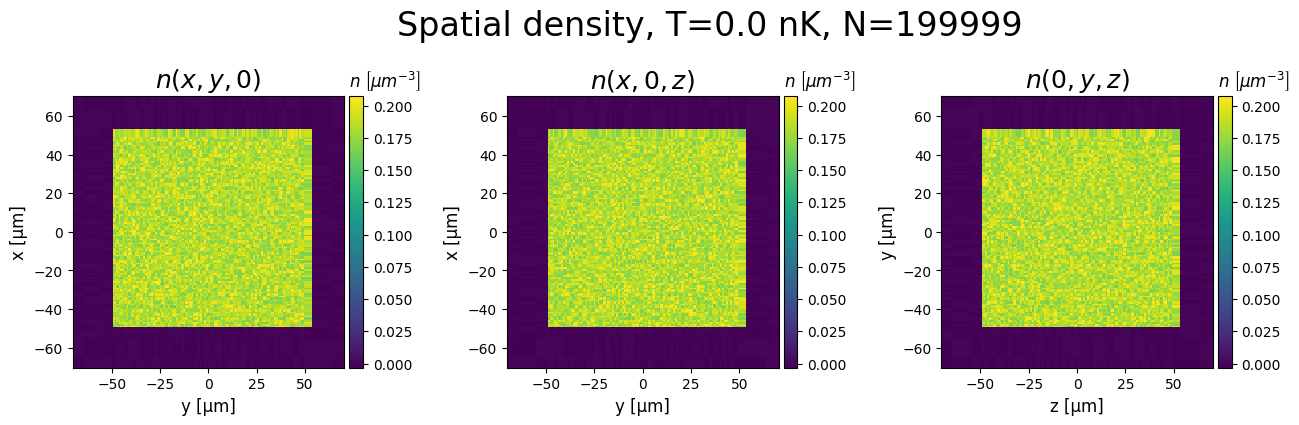

In [4]:
fg.plot_all()

In [17]:
bec = BoseGas(na23_harmonic)
bec.eval_density(use_TF=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

N_particles:  199884.81594826817


  0%|          | 0/1000 [00:37<?, ?it/s]

Convergence reached after 0 iterations.


In [18]:
bec1 = BoseGas(na23_harmonic)
bec1.eval_density(use_TF=True)

  0%|          | 0/1000 [00:01<?, ?it/s]

Convergence reached after 0 iterations.


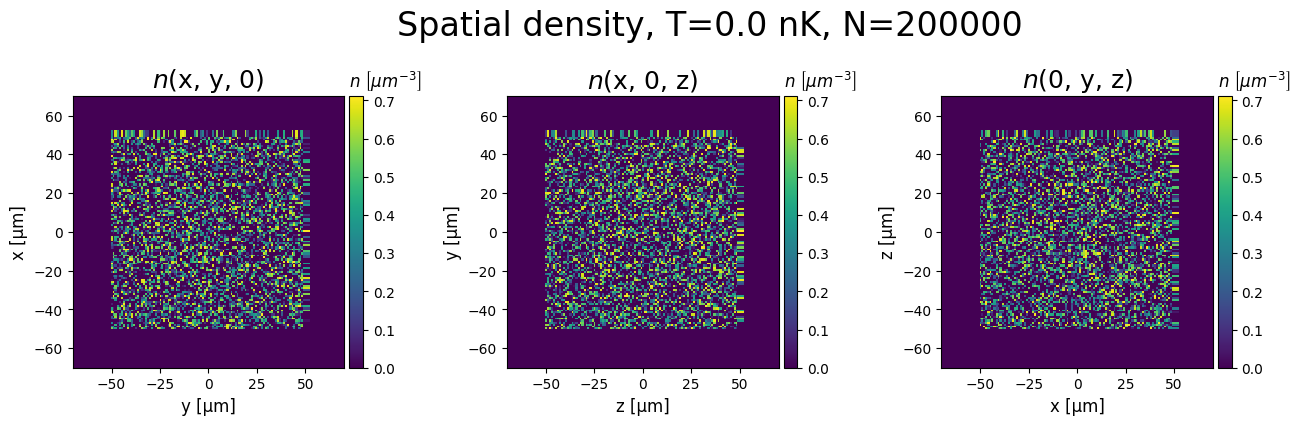

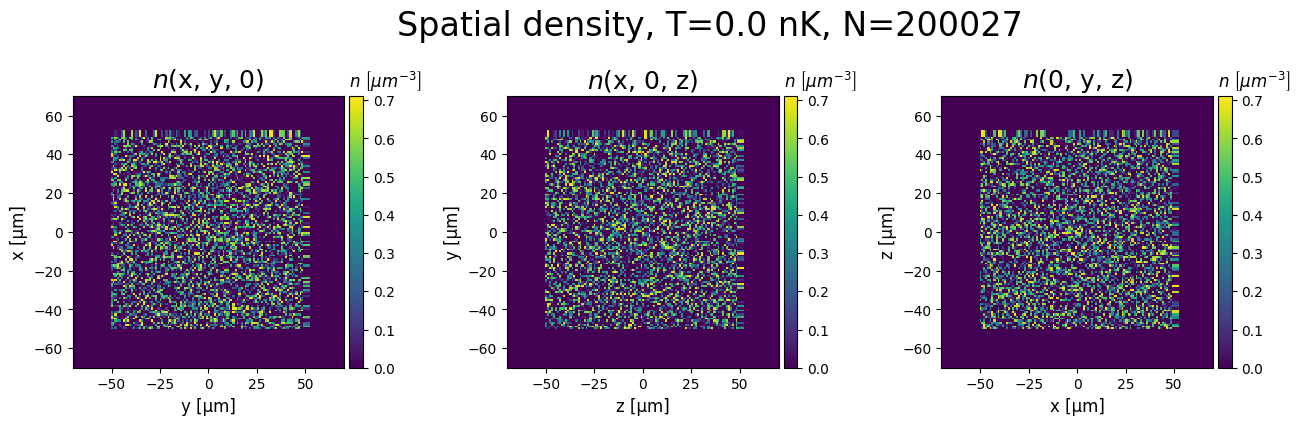

In [20]:
bec.plot_density_2d('n', num_points=500)
bec1.plot_density_2d('n', num_points=500)

array([<Axes: title={'center': '$n(x,0,0)$'}, xlabel='$x \\; \\left[\\mu m\\right]$', ylabel='$n(x,0,0) \\; \\left[\\mu m^{-3}\\right]$'>,
       <Axes: title={'center': '$n(0,y,0)$'}, xlabel='$y \\; \\left[\\mu m\\right]$', ylabel='$n(0,y,0) \\; \\left[\\mu m^{-3}\\right]$'>,
       <Axes: title={'center': '$n(0,0,z)$'}, xlabel='$z \\; \\left[\\mu m\\right]$', ylabel='$n(0,0,z) \\; \\left[\\mu m^{-3}\\right]$'>],
      dtype=object)

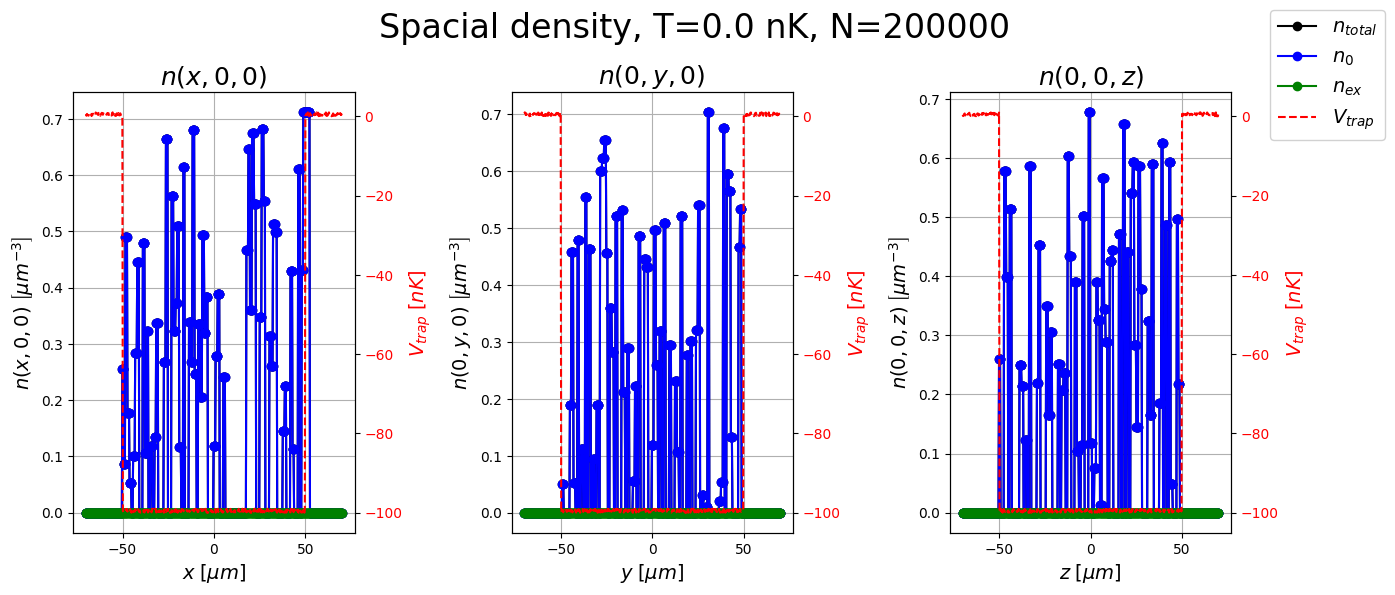

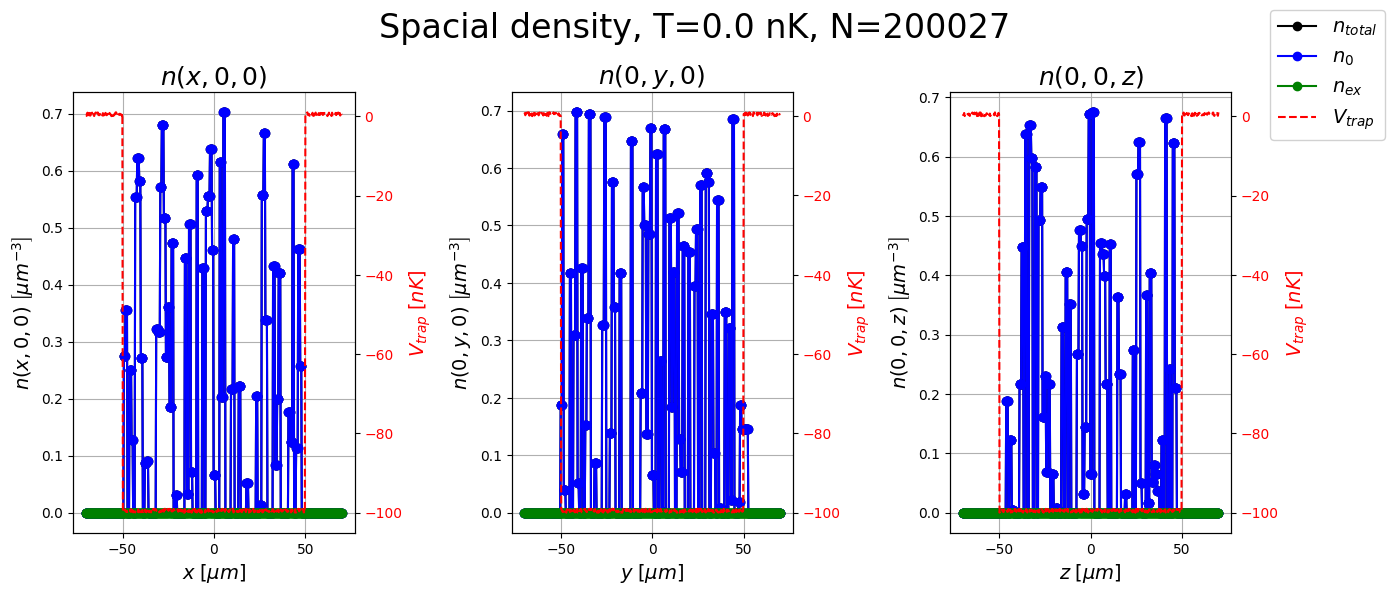

In [21]:
bec.plot_density_1d(num_points=500)
bec1.plot_density_1d(num_points=500)

In [2]:
becs = {}
inhomogenities = np.linspace(0, 0.02, 11)

for inhom in inhomogenities:
    na23_box = ParticleProps(
        name="Na23",
        species="boson",
        m=22.989768*u.u,
        N_particles=200000,
        T=0, #45*u.nK,
        a_s=2.75*u.nm,
        domain=(-70, 70)*u.um,
        #V_trap=harmonic_trap,
        V_trap=box_trap,
        trap_depth=100,
        box_width=(100,100,100),
        inhomogenity=inhom,
    )
    
    bec = BoseGas(na23_box)
    bec.eval_density(use_TF=False)
    becs[inhom] = bec

  0%|          | 0/1000 [00:00<?, ?it/s]

N_particles:  232655373.32448217


  0%|          | 0/1000 [02:50<?, ?it/s]

Convergence reached after 0 iterations.



  0%|          | 0/1000 [00:00<?, ?it/s]

N_particles:  235250079.1589624


  0%|          | 0/1000 [03:40<?, ?it/s]

Convergence reached after 0 iterations.



  0%|          | 0/1000 [00:00<?, ?it/s]

N_particles:  199975.75524235342


  0%|          | 0/1000 [00:35<?, ?it/s]

Convergence reached after 0 iterations.



  0%|          | 0/1000 [00:00<?, ?it/s]

N_particles:  200077.75742247497


  0%|          | 0/1000 [00:35<?, ?it/s]

Convergence reached after 0 iterations.



  0%|          | 0/1000 [00:00<?, ?it/s]

N_particles:  200151.57089015402


  0%|          | 0/1000 [00:36<?, ?it/s]

Convergence reached after 0 iterations.



  0%|          | 0/1000 [00:00<?, ?it/s]

N_particles:  199884.76455516333


  0%|          | 0/1000 [00:35<?, ?it/s]

Convergence reached after 0 iterations.



  0%|          | 0/1000 [00:00<?, ?it/s]

N_particles:  199859.81166094853


  0%|          | 0/1000 [00:36<?, ?it/s]

Convergence reached after 0 iterations.



  0%|          | 0/1000 [00:00<?, ?it/s]

N_particles:  199898.67505237734


  0%|          | 0/1000 [00:34<?, ?it/s]

Convergence reached after 0 iterations.



  0%|          | 0/1000 [00:00<?, ?it/s]

N_particles:  200014.8815451626


  0%|          | 0/1000 [00:34<?, ?it/s]

Convergence reached after 0 iterations.



  0%|          | 0/1000 [00:00<?, ?it/s]

N_particles:  200012.95322277956


  0%|          | 0/1000 [00:34<?, ?it/s]

Convergence reached after 0 iterations.



  0%|          | 0/1000 [00:00<?, ?it/s]

N_particles:  200072.74544067707


  0%|          | 0/1000 [00:34<?, ?it/s]

Convergence reached after 0 iterations.


In [3]:
variances = []

for inhom, bec in becs.items():
    variances.append((np.std(bec.n_array)).value)
    print(inhom, bec.mu)

0.0 -99.85649366783856 nK
0.002 -99.7585956115639 nK
0.004 -99.66596985563194 nK
0.006 -99.59349152704358 nK
0.008 -99.53348896376852 nK
0.01 -99.48126427066472 nK
0.012 -99.43480266368182 nK
0.014 -99.39261449774028 nK
0.016 -99.35374953831379 nK
0.018000000000000002 -99.31758617740168 nK
0.02 -99.27290430836177 nK


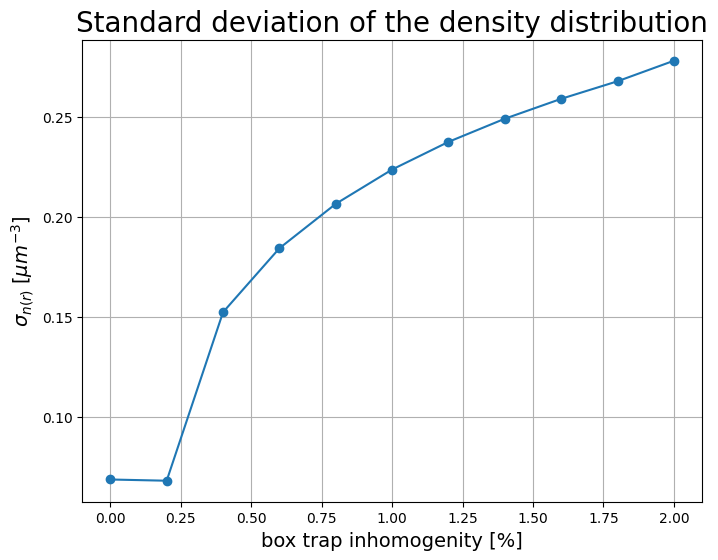

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(100*inhomogenities, variances, marker='o')
ax.set_xlabel('box trap inhomogenity [%]', fontsize=14)
ax.set_ylabel(r'$\sigma_{n(r)} \; [\mu m^{-3}]$', fontsize=14)
ax.set_title('Standard deviation of the density distribution', fontsize=20)
ax.grid(True)

fig.savefig('20240116_box_trap_inhomogenity.png', dpi=300, bbox_inches='tight')

In [7]:
becs.keys()

dict_keys([0.0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018000000000000002, 0.02])

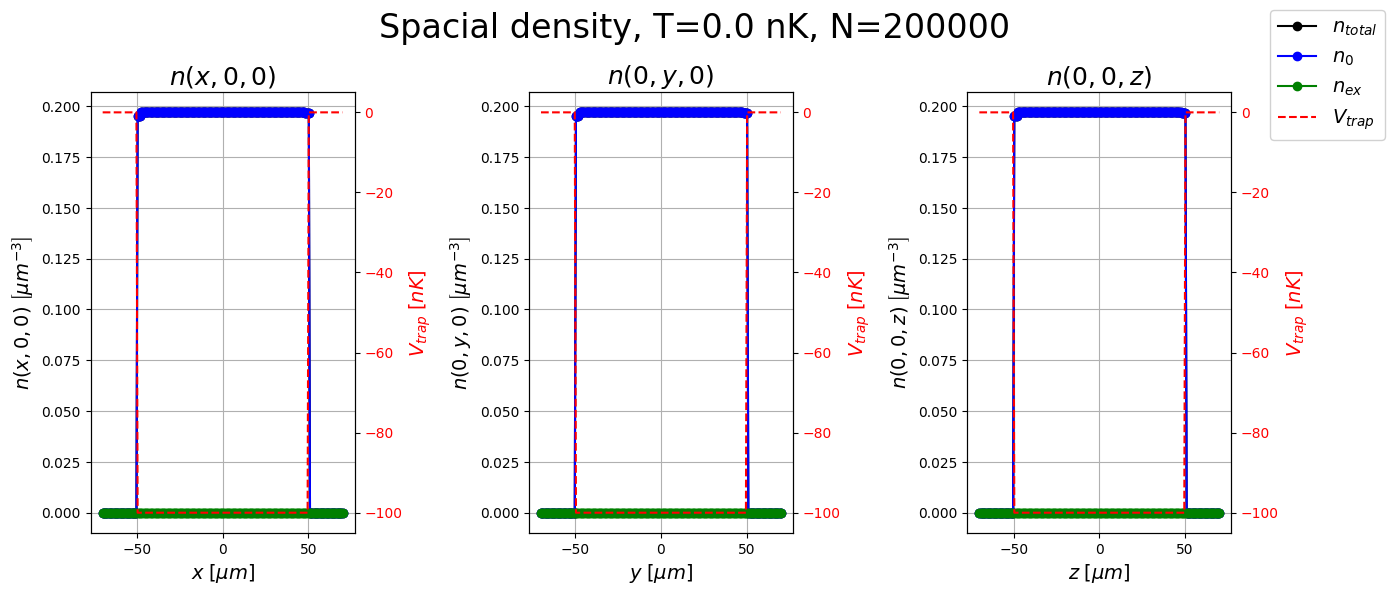

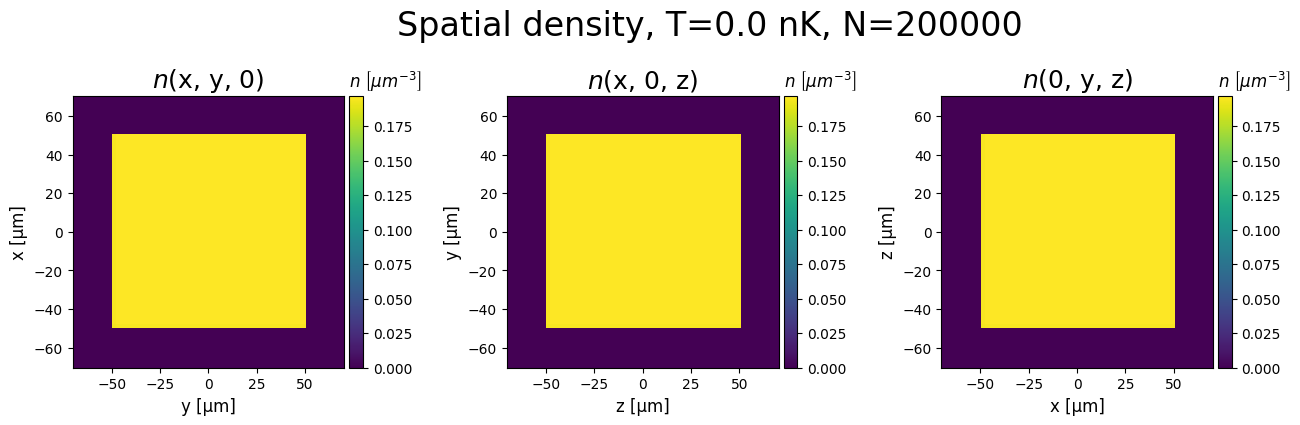

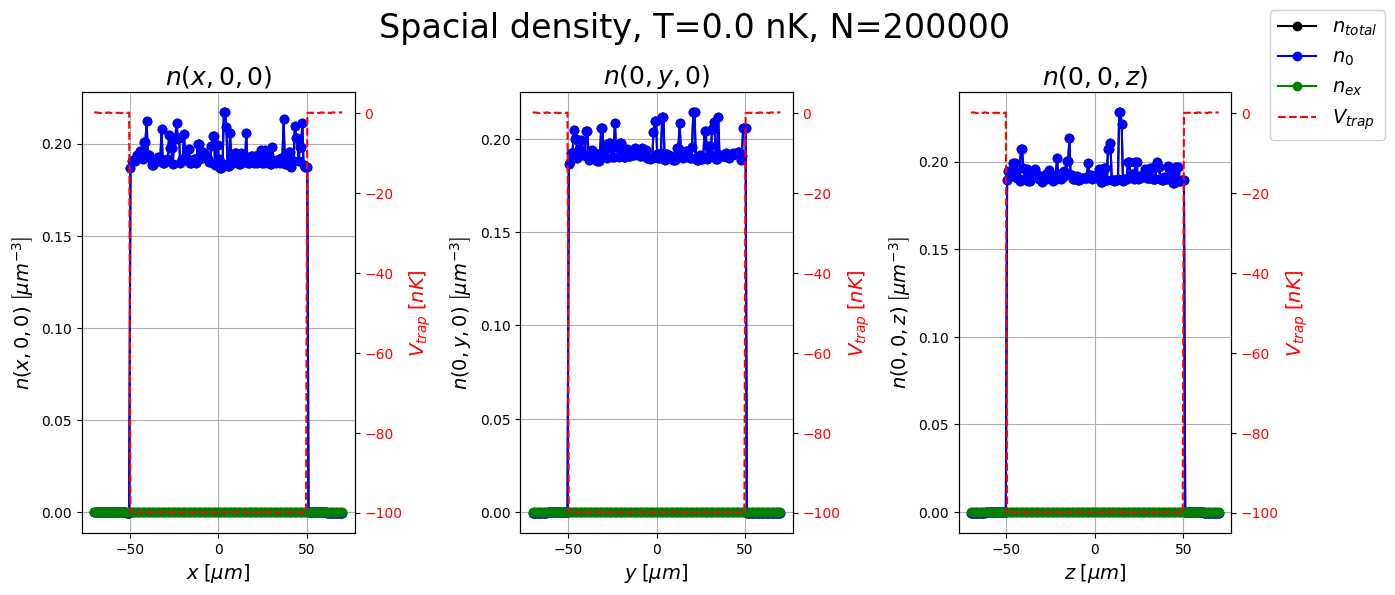

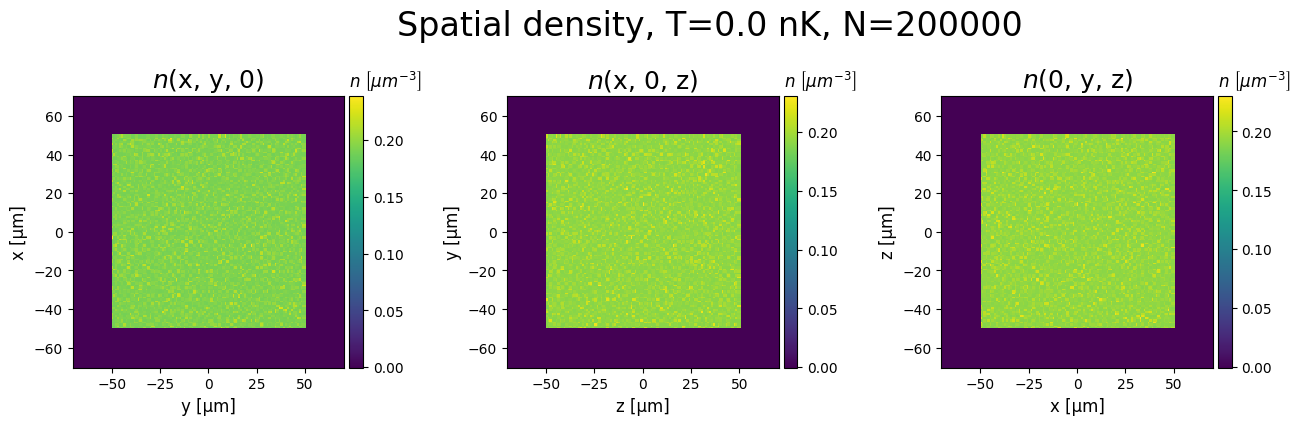

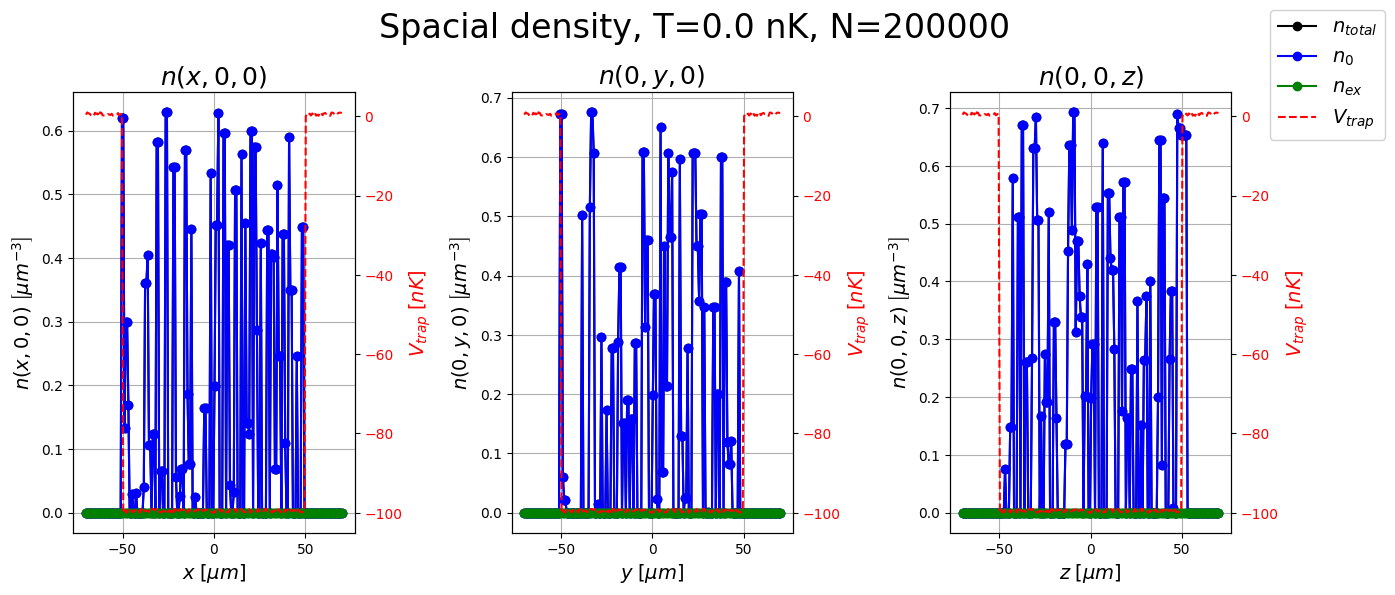

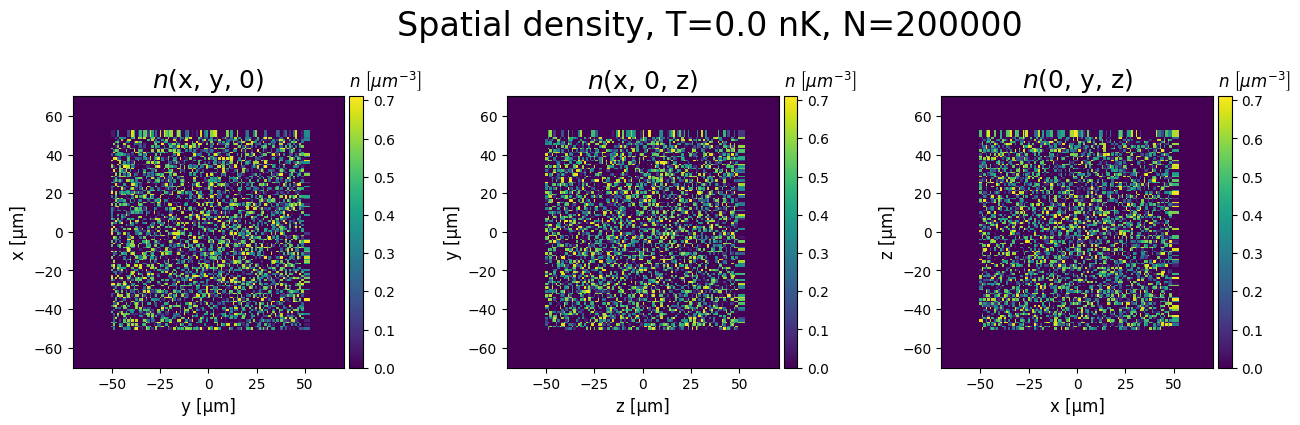

In [11]:
a = becs[0.0].plot_density_1d(filename='20240116_box_trap_1d_i0.png')
b = becs[0.0].plot_density_2d('n', filename='20240116_box_trap_2d_i0.png')
c = becs[0.002].plot_density_1d(filename='20240116_box_trap_1d_i002.png')
d = becs[0.002].plot_density_2d('n', filename='20240116_box_trap_2d_i002.png')
e = becs[0.01].plot_density_1d(filename='20240116_box_trap_1d_i01.png')
f = becs[0.01].plot_density_2d('n', filename='20240116_box_trap_2d_i01.png')

In [7]:
a = np.array([[1, 2, 4, 8], [3, 6, 9, 12]])
np.square(a)

array([[  1,   4,  16,  64],
       [  9,  36,  81, 144]])

AttributeError: 'FermiGas' object has no attribute 'x'

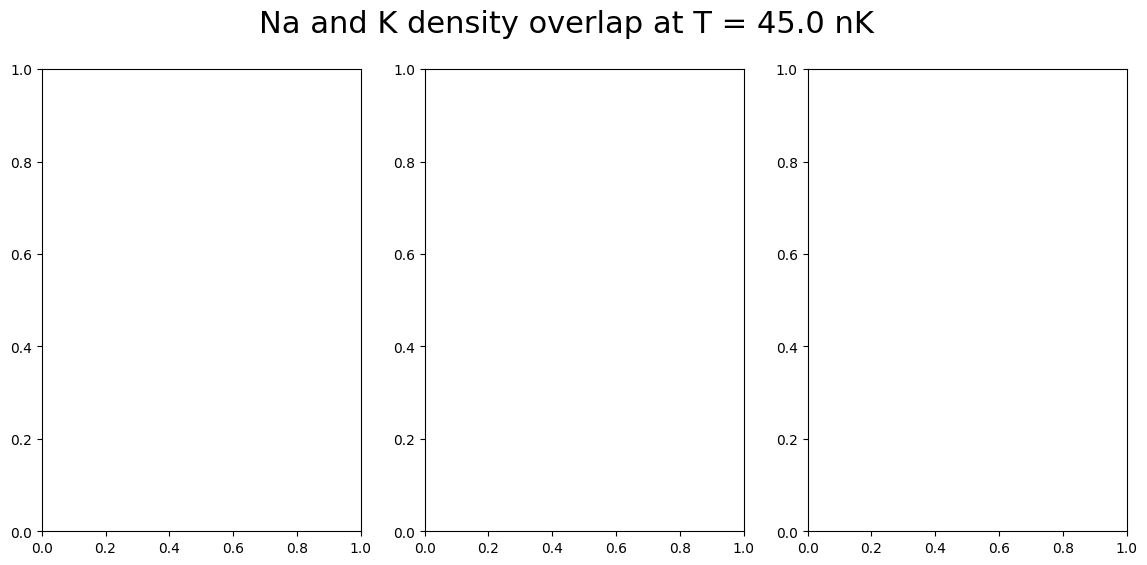

In [5]:
fig, axs = plt.subplots(ncols=3, figsize=(14,6))
fig.suptitle("Na and K density overlap at T = " + str(na23_harmonic.T), fontsize=22)

axs[0].plot(fg.x, fg.n_array[:,fg.num_grid_points[1]//2,fg.num_grid_points[2]//2], label="K40", marker="o")
axs[0].plot(bec.x, bec.n_array[:,bec.num_grid_points[1]//2,bec.num_grid_points[2]//2], label="Na23 n", marker="o")
axs[0].plot(bec.x, bec.n0_array[:,bec.num_grid_points[1]//2,bec.num_grid_points[2]//2], label="Na23 n0", marker="o")
axs[0].set_title(r"n(x,0,0)", fontsize=18)
axs[0].set_xlabel(r"$x \; [\mu m]$", fontsize=14)
axs[0].set_ylabel(r"$n \; [\mu m^{-3}]$", fontsize=14)
axs[0].grid(True)
axs[0].legend()

axs[1].plot(fg.y, fg.n_array[fg.num_grid_points[0]//2,:,fg.num_grid_points[2]//2], label="K40", marker="o")
axs[1].plot(bec.y, bec.n_array[bec.num_grid_points[0]//2,:,bec.num_grid_points[2]//2], label="Na23 n", marker="o")
axs[1].plot(bec.y, bec.n0_array[bec.num_grid_points[0]//2,:,bec.num_grid_points[2]//2], label="Na23 n0", marker="o")
axs[1].set_title(r"n(0,y,0)", fontsize=18)
axs[1].set_xlabel(r"$y \; [\mu m]$", fontsize=14)
axs[1].set_ylabel(r"$n \; [\mu m^{-3}]$", fontsize=14)
axs[1].grid(True)
axs[1].legend()

axs[2].plot(fg.z, fg.n_array[fg.num_grid_points[0]//2,fg.num_grid_points[1]//2, :], label="K40", marker="o")
axs[2].plot(bec.z, bec.n_array[bec.num_grid_points[0]//2,bec.num_grid_points[1]//2, :], label="Na23 n", marker="o")
axs[2].plot(bec.z, bec.n0_array[bec.num_grid_points[0]//2,bec.num_grid_points[1]//2, :], label="Na23 n0", marker="o")
axs[2].set_title(r"n(0,0,z)", fontsize=18)
axs[2].set_xlabel(r"$z \; [\mu m]$", fontsize=14)
axs[2].set_ylabel(r"$n \; [\mu m^{-3}]$", fontsize=14)
axs[2].grid(True)
axs[2].legend()

fig.tight_layout()

In [ ]:
bec.condensate_fraction

<Quantity 0.0738234>

In [ ]:
na23_harmonicT0 = na23_harmonic.copy()
na23_harmonicT0.T = 0*u.nK
k40_harmonicT0 = k40_harmonic.copy()
k40_harmonicT0.T = 0*u.nK

In [ ]:
fgT0 = FermiGas(k40_harmonicT0, num_grid_points=101)
fgT0.eval_density(num_q_values=101)

  0%|          | 0/1000 [00:00<?, ?it/s]

  5%|▍         | 47/1000 [00:01<00:32, 29.77it/s]

Convergence reached after 47 iterations.


In [ ]:
becT0 = BEC(na23_harmonicT0, num_grid_points=101)
becT0.eval_density(num_q_values=101)

NameError: name 'BEC' is not defined

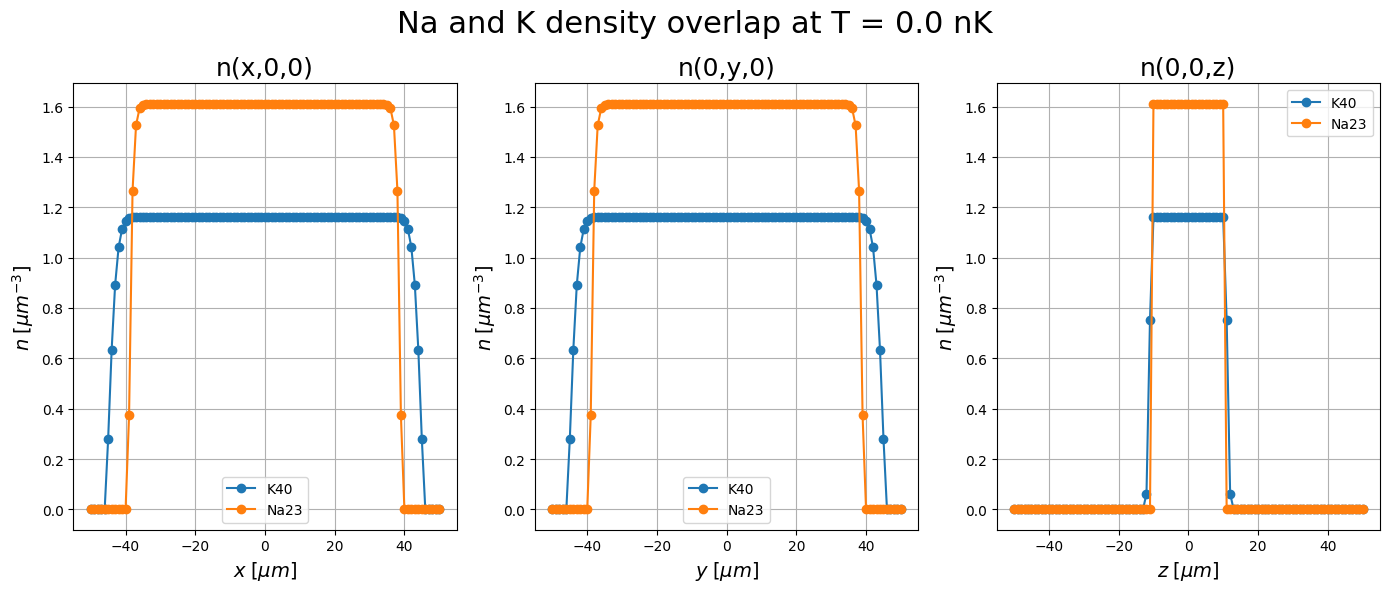

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(14,6))
fig.suptitle("Na and K density overlap at T = " + str(na23_harmonicT0.T), fontsize=22)

axs[0].plot(fgT0.x, fgT0.n_array[:,fgT0.num_grid_points[1]//2,fgT0.num_grid_points[2]//2], label="K40", marker="o")
axs[0].plot(becT0.x, becT0.n_array[:,bec.num_grid_points[1]//2,bec.num_grid_points[2]//2], label="Na23", marker="o")
axs[0].set_title(r"n(x,0,0)", fontsize=18)
axs[0].set_xlabel(r"$x \; [\mu m]$", fontsize=14)
axs[0].set_ylabel(r"$n \; [\mu m^{-3}]$", fontsize=14)
axs[0].grid(True)
axs[0].legend()

axs[1].plot(fgT0.y, fgT0.n_array[fgT0.num_grid_points[0]//2,:,fgT0.num_grid_points[2]//2], label="K40", marker="o")
axs[1].plot(becT0.y, becT0.n_array[bec.num_grid_points[0]//2,:,bec.num_grid_points[2]//2], label="Na23", marker="o")
axs[1].set_title(r"n(0,y,0)", fontsize=18)
axs[1].set_xlabel(r"$y \; [\mu m]$", fontsize=14)
axs[1].set_ylabel(r"$n \; [\mu m^{-3}]$", fontsize=14)
axs[1].grid(True)
axs[1].legend()

axs[2].plot(fgT0.z, fgT0.n_array[fgT0.num_grid_points[0]//2,fgT0.num_grid_points[1]//2, :], label="K40", marker="o")
axs[2].plot(becT0.z, becT0.n_array[bec.num_grid_points[0]//2,bec.num_grid_points[1]//2, :], label="Na23", marker="o")
axs[2].set_title(r"n(0,0,z)", fontsize=18)
axs[2].set_xlabel(r"$z \; [\mu m]$", fontsize=14)
axs[2].set_ylabel(r"$n \; [\mu m^{-3}]$", fontsize=14)
axs[2].grid(True)
axs[2].legend()

fig.tight_layout()

  0%|          | 0/1000 [00:00<?, ?it/s]

  4%|▍         | 38/1000 [00:01<00:41, 22.91it/s]


Convergence reached after 38 iterations.


  3%|▎         | 32/1000 [01:52<56:39,  3.51s/it] 


Convergence reached after 32 iterations.


  3%|▎         | 32/1000 [01:52<56:57,  3.53s/it]


Convergence reached after 32 iterations.


  4%|▍         | 38/1000 [02:16<57:30,  3.59s/it]  


Convergence reached after 38 iterations.


  3%|▎         | 31/1000 [01:56<1:00:41,  3.76s/it]

Convergence reached after 31 iterations.



/home/lelo/Dokumente/lightmat/quantum_statistics/analyze_gas.py:217: RuntimeWarning: divide by zero encountered in power
  return 1 - (T / T_c)**alpha


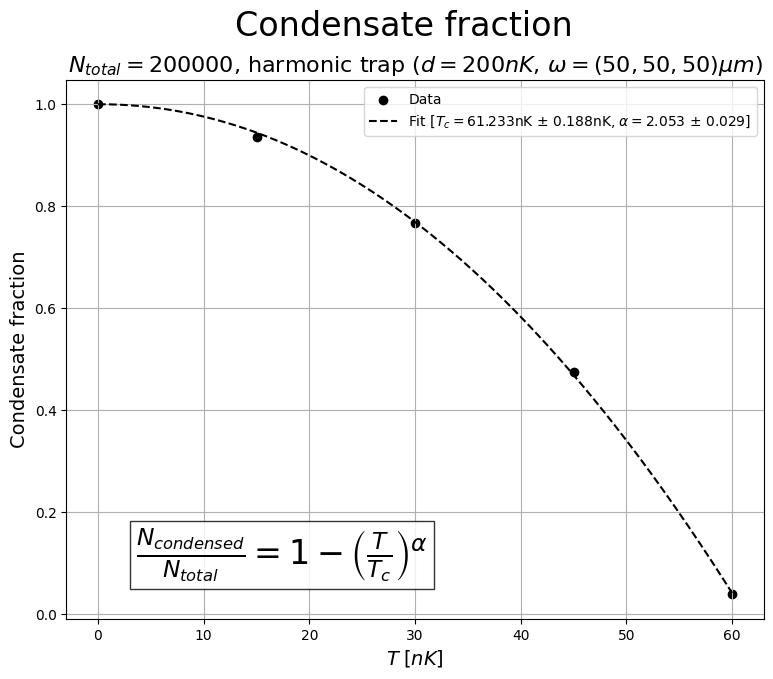

In [ ]:
na23_harmonic = ParticleProps(
    name="Na23",
    species="boson",
    m=22.989768*u.u,
    N_particles=200000,
    T=40*u.nK,
    a_s=2.75*u.nm,
    domain=(-50, 50)*u.um,
    #V_trap=harmonic_trap,
    #V_trap=box_trap,
    #V_trap=box_2d_harmonic_1d_trap,
    #trap_depth=100,
    #box_width=(100,100,100),
    #waist=50,
    V_trap=ring_beam_trap,
    flat_sizes=(100, 100, 20)*u.um,
    boundary_waists=(6, 6, 13)*u.um,
    blue_trap_hight=3*100*u.nK,
    red_trap_depth=100*u.nK,
    inhomogenity=0,
)

Ts = np.linspace(0, 60, 5)*u.nK
becs = analyze_bec(Ts, na23_harmonic)
plot_condens_frac(Ts, becs)